In [1]:
# Задание 2
# Имеются результаты A/B теста, в котором двум группам пользователей предлагались 
# различные наборы акционных предложений. 
# Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. 
# При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

# Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного
# решения и как?

In [1]:
import pandas as pd
from scipy import stats
import seaborn as sns

In [4]:
df = pd.read_csv('C:/Users/work/Desktop/Jupyter/KARPOV_courses/FINAL PROJECT/project_1/Проект_1_Задание_2.csv', sep=';')

In [5]:
df.head()

user_id  revenue testgroup
0        1        0         b
1        2        0         a
2        3        0         a
3        4        0         b
4        5        0         b

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [7]:
df.describe()

user_id        revenue
count  404770.000000  404770.000000
mean   202385.500000      26.083435
std    116847.178567     681.652928
min         1.000000       0.000000
25%    101193.250000       0.000000
50%    202385.500000       0.000000
75%    303577.750000       0.000000
max    404770.000000   37433.000000

In [8]:
df.user_id.nunique()

404770

In [9]:
# все user_id - уникальные; кол-во user_id = кол-ву revenue => АРС=1; 
# ARPPU = AvPrice;

In [10]:
# сведем данные теста в таблицу

In [11]:
users_a_count = df.query('testgroup == "a" ').revenue.count()
customers_a_count = df.query('testgroup == "a" & revenue > 0').revenue.count()
revenue_a = df.query('testgroup == "a" & revenue > 0').revenue.sum()

In [12]:
users_b_count = df.query('testgroup == "b" ').revenue.count()
customers_b_count = df.query('testgroup == "b" & revenue > 0').revenue.count()
revenue_b = df.query('testgroup == "b" & revenue > 0').revenue.sum()

In [13]:
test_result = pd.DataFrame({'group': ['A', 'B'], 'users': [users_a_count, users_b_count], 
                            'buyers': [customers_a_count, customers_b_count], 'revenue': [revenue_a, revenue_b]})

In [14]:
test_result

group   users  buyers  revenue
0     A  202103    1928  5136189
1     B  202667    1805  5421603

In [15]:
# добавим метрики

In [16]:
test_result['C1'] = round(test_result.buyers / test_result.users * 100, 2)
test_result['AvPrice'] = round(test_result.revenue / test_result.buyers, 2)
test_result['ARPU'] = round(test_result.revenue / test_result.users, 2)
test_result

group   users  buyers  revenue    C1  AvPrice   ARPU
0     A  202103    1928  5136189  0.95  2664.00  25.41
1     B  202667    1805  5421603  0.89  3003.66  26.75

In [17]:
# Результат теста: в тестовой группе revenue выше на 5,26% средний чек выше на 11,3%; ARPU выше на 5%;
# конверсии в покупку ниже на 0,06 п.п. 

In [18]:
# с помощью статистических методов проверим значимость различия ARPU в группах, 
# создадим контрольный и тестовый дата фреймы

In [19]:
control_df = df.query('testgroup == "a"')
test_df = df.query('testgroup == "b"')

In [20]:
# среднее значение revenue в данных дата фреймах = ARPU

In [21]:
# проверим нормальность распределения revenue с помощью Теста Шапиро-Уилка 

In [22]:
stats.shapiro(control_df.revenue.sample(1000, random_state=17))

ShapiroResult(statistic=0.06614720821380615, pvalue=0.0)

In [23]:
stats.shapiro(test_df.revenue.sample(1000, random_state=17))

ShapiroResult(statistic=0.06715953350067139, pvalue=0.0)

In [24]:
# в обоих случаях распределение не нормальное (р<0.05)
# для сравнения средних значений используем U-критерий Манна-Уитни
# Н0 - статистически значимых различий между ARPU в обоих группах нет
# Н1 - разница ARPU в обоих группах статистически значима

In [25]:
stats.mannwhitneyu(test_df.revenue, control_df.revenue.sample(100, random_state=17))

MannwhitneyuResult(statistic=10043100.0, pvalue=0.17158075805425538)

In [36]:
stats.ttest_ind(test_df.revenue, control_df.revenue, equal_var=False)

Ttest_indResult(statistic=0.6234876562792212, pvalue=0.5329647014130866)

In [26]:
# р>0.05, следовательно у нас нет оснований отклонить Н0 

<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

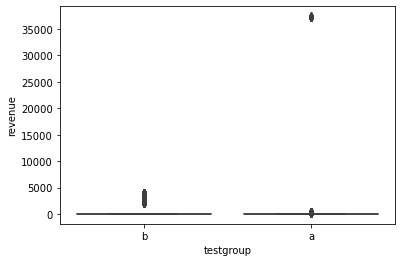

In [27]:
# визуализация
sns.boxplot(x=df.testgroup, y=df.revenue)

In [28]:
# проверим значимость различия AvPrice в группах, для этого создадим следующие дата фреймы

In [29]:
AvPrice_control_df = df.query('testgroup == "a" & revenue > 0')
AvPrice_test_df = df.query('testgroup == "b" & revenue > 0')

In [30]:
stats.shapiro(AvPrice_control_df.revenue)

ShapiroResult(statistic=0.26679253578186035, pvalue=0.0)

In [31]:
stats.shapiro(AvPrice_test_df.revenue.sample(100, random_state=17))

ShapiroResult(statistic=0.9424388408660889, pvalue=0.0002724009391386062)

In [32]:
# в обоих случаях распределение не нормальное (р<0.05)
# для сравнения средних значений используем U-критерий Манна-Уитни
# Н0 - статистически значимых различий между AvPrice в обоих группах нет
# Н1 - разница AvPrice в обоих группах статистически значима

In [33]:
stats.mannwhitneyu(AvPrice_test_df.revenue, AvPrice_control_df.revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

In [34]:
# р<0.05, это дает нам основания отклонить Н0 и принять Н1 - AvPrice групп различаются стат. значимо, 
# т.е набор акционных предложений тестовой группы увеличил AvPrice

<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

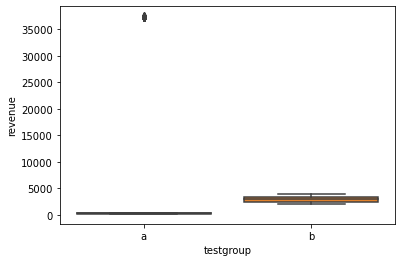

In [35]:
# визуализация
d = df.query('revenue > 0')
sns.boxplot(x=d.testgroup, y=d.revenue)

In [29]:
# Для принятия правильного решения о выборе набора предложений нам не хватает данных 
# о маркетиноговых расходах на 
# предоставление акционных предложений(сумма акционной скидки + р-ды на промоушен). 
# Имея данные о маркетинговых расходах можно рассчитать ROMI и выбраать вариант с большим показателем.